In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import re

## Download Data

We're downloading the dialouge from all of Shakespeare's plays via Kaggle. The below cell contains what you'd run in your terminal, but to do so you need to have a Kaggle Account/API Key.

In [2]:
import subprocess
import sys
import os
# subprocess.run("kaggle datasets download -d kingburrito666/shakespeare-plays && unzip shakespeare-plays.zip",shell=True)
plays_df = pd.read_csv("Shakespeare_data.csv")
# Drop stage directions (where there isn't an act/scene/line)
plays_df = plays_df[pd.notna(plays_df['ActSceneLine'])]
plays_df[['Act','Scene','Line']] = plays_df['ActSceneLine'].str.split('.',expand = True).astype(float)
plays_df = plays_df.drop('ActSceneLine',axis=1)
# Standardize play casing
plays_df['Play'] = plays_df['Play'].apply(lambda x: x.title())

### Remove plays defined as "histories"

In [3]:
histories = ["King John", "Henry Iv", "Henry Vi Part 1", "Henry V",
            "Henry Vi Part 2", "Henry Vi Part 3", "Henry Viii", "Richard Ii", 
             "Richard Iii"]
plays_df = plays_df[~plays_df["Play"].isin(histories)]
print("{} rows and {} columns".format(*plays_df.shape))
plays_df.head()

77597 rows and 8 columns


,Dataline,Play,PlayerLinenumber,Player,PlayerLine,Act,Scene,Line
12663,12664,Alls Well That Ends Well,1.0,COUNTESS,"In delivering my son from me, I bury a second ...",1.0,1.0,1.0
12664,12665,Alls Well That Ends Well,2.0,BERTRAM,"And I in going, madam, weep o'er my father's d...",1.0,1.0,2.0
12665,12666,Alls Well That Ends Well,2.0,BERTRAM,"anew: but I must attend his majesty's command, to",1.0,1.0,3.0
12666,12667,Alls Well That Ends Well,2.0,BERTRAM,"whom I am now in ward, evermore in subjection.",1.0,1.0,4.0
12667,12668,Alls Well That Ends Well,3.0,LAFEU,"You shall find of the king a husband, madam, you,",1.0,1.0,5.0


All the plays we have to work with

In [4]:
play_list = plays_df["Play"].unique()
play_list
print(play_list)

['Alls Well That Ends Well' 'As You Like It' 'Antony And Cleopatra'
 'A Comedy Of Errors' 'Coriolanus' 'Cymbeline' 'Hamlet' 'Julius Caesar'
 'King Lear' 'Loves Labours Lost' 'Macbeth' 'Measure For Measure'
 'Merchant Of Venice' 'Merry Wives Of Windsor' 'A Midsummer Nights Dream'
 'Much Ado About Nothing' 'Othello' 'Pericles' 'Romeo And Juliet'
 'Taming Of The Shrew' 'The Tempest' 'Timon Of Athens' 'Titus Andronicus'
 'Troilus And Cressida' 'Twelfth Night' 'Two Gentlemen Of Verona'
 'A Winters Tale']


In [304]:
play_name = "A Winters Tale"
single_play = plays_df[(plays_df['Play'] == play_name)]
single_play.head()

,Dataline,Play,PlayerLinenumber,Player,PlayerLine,Act,Scene,Line
107910,107911,A Winters Tale,1.0,ARCHIDAMUS,"If you shall chance, Camillo, to visit Bohemia...",1.0,1.0,1.0
107911,107912,A Winters Tale,1.0,ARCHIDAMUS,the like occasion whereon my services are now on,1.0,1.0,2.0
107912,107913,A Winters Tale,1.0,ARCHIDAMUS,"foot, you shall see, as I have said, great",1.0,1.0,3.0
107913,107914,A Winters Tale,1.0,ARCHIDAMUS,difference betwixt our Bohemia and your Sicilia.,1.0,1.0,4.0
107914,107915,A Winters Tale,2.0,CAMILLO,"I think, this coming summer, the King of Sicilia",1.0,1.0,5.0


## Organize play by act/scene and keep track of who speaks in which

In [305]:
# Group the play dataframe by each character to get how often they speak
top_characters = single_play.groupby(['Player']).size().reset_index()
top_characters.rename(columns = {0: 'Count'}, inplace = True)
# Get top 20 Characters
top_characters = top_characters[top_characters["Count"] > 5]
top_characters

,Player,Count
0,ANTIGONUS,112
1,ARCHIDAMUS,22
2,AUTOLYCUS,294
3,CAMILLO,299
4,CLEOMENES,23
5,Clown,184
6,DION,28
7,DORCAS,12
8,EMILIA,21
9,FLORIZEL,206


### Create Graph and add all the characters

In [306]:
character_graph = nx.Graph()
character_graph.add_nodes_from(top_characters["Player"])

### Go scene by scene and add links between all the characters who spoke in that scene

We're updating the weights as we go scene by scene so that  

In [307]:
from itertools import combinations
# Group the play by the Act/Scene and get how much each character spoke in that scene 
character_counts = single_play.groupby(['Act','Scene','Player']).size().reset_index()
character_counts = character_counts[character_counts["Player"].isin(top_characters["Player"])]
character_counts.rename(columns = {0: 'Count'}, inplace = True)

# Go scene by scene
for (act,scene), counts in character_counts.groupby(['Act','Scene']):
    # Get all the characters that are in that scene
    characters = counts["Player"].tolist()
    # If a scene contains characters [A,B,C] we want are graph to 
    # contain the edges [(A,B),(A,C),(B,C)]
    pairs = list(combinations(characters,2))
    for (a_char, b_char) in pairs:
        a_count = float(counts[counts["Player"] == a_char]["Count"])
        b_count = float(counts[counts["Player"] == b_char]["Count"])
        if character_graph.has_edge(a_char, b_char):
            # we added this one before, just increase the weight by one
            character_graph[a_char][b_char]['weight'] += 1
        else:
            # new edge. add with weight=1
            character_graph.add_edge(a_char, b_char, weight = a_count + b_count)

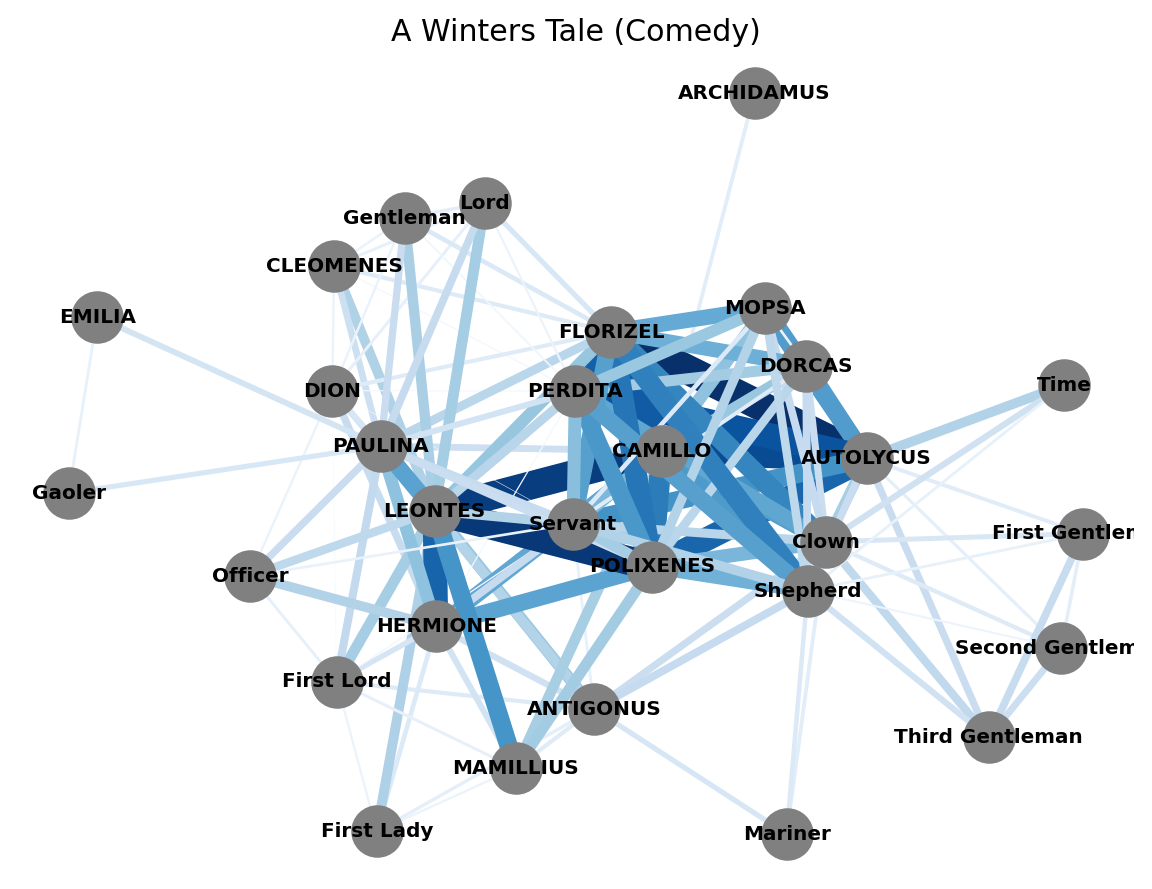

In [308]:
# drawing NX graph object
from networkx.drawing.nx_agraph import graphviz_layout
plt.figure(figsize = (8,6), dpi = 180)
plt.title("{} ({})".format(play_name,"Comedy" if play_name in comedies else "Tragedy"))

pos = graphviz_layout(character_graph, prog="neato")
# Divide all the weights by 30 so that the edges aren't super thick
weights = np.array([character_graph[u][v]['weight'] for u,v in character_graph.edges()])/30
kwargs = {
    "with_labels": True,
    "node_size": 400,
    "node_color": 'grey',
    "font_size": 8,
    "font_weight": 'semibold',
    "width": weights,
    "edge_color": weights, 
    "edge_cmap": plt.cm.Blues,
    "pos": pos
}
nx.draw_networkx(character_graph, **kwargs)
fig.tight_layout()
plt.axis('off')
plt.savefig("./visualizations/{}.png".format(play_name))
plt.show()
plt.close()

### Save the character graph to a file for later

In [309]:
nx.write_gpickle(character_graph, "./graphs/{}.gpickle".format(play_name))

# *Repeat with all other plays...*

# Calculate Heat Traces

The idea behind classifying these plays is that at some global and local levels, tragedies and comedies have different patterns of communication. This can be captured by simulating how the dialogue "flows" through the network. This uses the heat kernel and is directly analogous to modelling how heat diffuses throughout a system.

In [310]:
from sklearn.model_selection import train_test_split
comedies = ["A Midsummer Nights Dream", "A Comedy Of Errors", "Taming Of The Shrew",
            "Two Gentlemen Of Verona", "Loves Labours Lost", "The Tempest", 
            "A Winters Tale", "Cymbeline", "Pericles","Alls Well That Ends Well",
            "Measure For Measure", "Troilus And Cressida", "Twelfth Night", 
            "As You Like It", "Much Ado About Nothing", "Merchant Of Venice",
            "Merry Wives Of Windsor"]

tragedies = ["Macbeth","Titus Andronicus", "Romeo And Juliet", "King Lear",
            "Hamlet","Othello", "Julius Caesar", "Antony And Cleopatra", 
            "Coriolanus", "Timon Of Athens"]

# Split into training and testing data
data = np.array(comedies+tragedies)
labels = np.concatenate([np.full(len(comedies), "c"),np.full(len(tragedies), "t")])
# Label map
lm = {
    "c": ("Comedy","blue"),
    "t": ("Tragedy","red")
}
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.33, random_state=42)

## Calculate point of truth heat signature

250


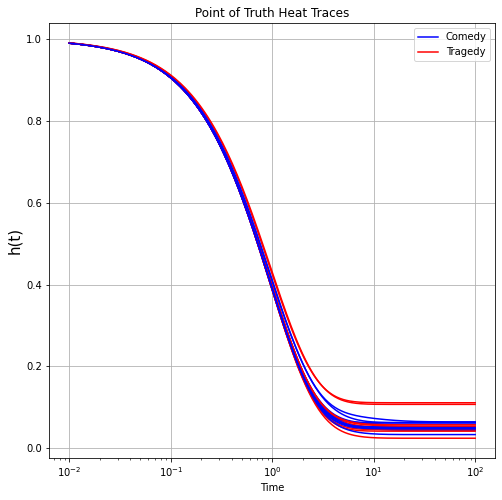

In [311]:
import netlsd
training_graphs = [nx.read_gpickle("./graphs/{}.gpickle".format(title)) for title in data_train]
kwargs = {
    "timescales": np.logspace(-2, 2, 250),
    "normalization": "empty"
}

get_sig = lambda title: netlsd.heat(nx.read_gpickle("./graphs/{}.gpickle".format(title)),**kwargs)

training_heat_sigs =[ for title in data_train]
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_title("Training Data Heat Traces")
ax.set_ylabel('h(t)', fontsize = 15)
ax.set_xlabel("Time")
ax.set_xscale('log')
ax.grid()
for sig,name,ptype in zip(training_heat_signatures,data_train,labels_train):
    ax.plot(kwargs["timescales"],sig, color=lm[ptype][1])

for key, item in lm.items():
    ax.plot([], [], label=item[0], color=item[1])
ax.legend(loc="best")
print(len(kwargs["timescales"]))

In [312]:
from netlsd import compare as l2_distance

def knn_predict(title, training_heat_sigs, training_titles, labels_train,k=5):
    # Read in the play's network and calculate it's heat trace signature using the same arguments as the training data
    graph_sig = get_sig(title)
    # Calcualte the distance between that graph and the training data's heat traces
    distances = [l2_distance(graph_sig,train_sig) for train_sig in training_heat_sigs]
    # I found that the most concise way to all three training inputs by distance was to 
    # put them in a dataframe first. If you're concerned about memory other options are probably
    # preferable
    total = pd.DataFrame({"Play Title": training_titles, "Play Type": labels_train, "Distance From Input": distances})
    total = total.sort_values("Distance From Input")
    print(total.head(k))
    return total["Play Type"].head(k).mode()[0]


pred = [knn_predict(play,training_heat_signatures,data_train,labels_train,k=5) for play in data_test]
print(pred)
print(labels_test)

                 Play Title Play Type  Distance From Input
13                Cymbeline         c             0.063386
7   Two Gentlemen Of Verona         c             0.096563
3               The Tempest         c             0.212311
9             Julius Caesar         t             0.221973
8                Coriolanus         t             0.229333
                Play Title Play Type  Distance From Input
14     Measure For Measure         c             0.036576
4      Taming Of The Shrew         c             0.036642
10        Titus Andronicus         t             0.042859
15  Much Ado About Nothing         c             0.045618
12               King Lear         t             0.057472
             Play Title Play Type  Distance From Input
8            Coriolanus         t             0.011087
9         Julius Caesar         t             0.015994
3           The Tempest         c             0.032604
0  Antony And Cleopatra         t             0.038252
2    Loves Labours Lost

In [313]:
### Create confusion matrix

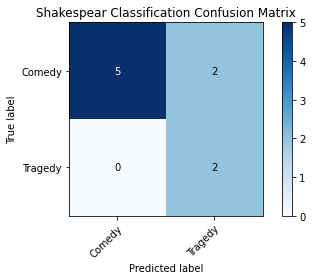

In [317]:
from sklearn.metrics import confusion_matrix
classes = ["Comedy", "Tragedy"]
cm = confusion_matrix(labels_test, pred)
title = 'Shakespear Classification Confusion Matrix'
    
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes, yticklabels=classes,
        title=title,
        ylabel='True label',
        xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
thresh = cm.max() / 2.
fmt = 'd'
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.savefig("./visualizations/confusion_mat.png")